# Complex networks: theory and applications
## Assignment 1: evaulation of graph centralities

#### Andrea Senacheribbe

---

In [1]:
figpath="figures/"

In [2]:
import numpy as np
import scipy.sparse as sparse, scipy.sparse.csgraph as sgraph, scipy.sparse.linalg as slinalg
import matplotlib.pyplot as plt, matplotlib.cm as cm
from numba import jit

## Input graph:

#### Protein-protein interaction in Homo Sapiens
http://konect.uni-koblenz.de/networks/reactome

node $\rightarrow$ protein   
edge $\rightarrow$ interaction

In [ ]:
!wget -N http://konect.uni-koblenz.de/downloads/tsv/reactome.tar.bz2
!tar xvjf reactome.tar.bz2

In [4]:
input_file="reactome/out.reactome"

undirected=True

## Reading and processing the graph

In [5]:
edges=np.loadtxt(input_file, dtype=np.uint32, comments=['%', '#'])
edges=edges[edges[:, 0] != edges[:, 1]] #remove self loops

if np.min(edges)==1: # if nodes numbering starts from 1
    edges-=1

dim=np.max(edges)+1

in_graph=sparse.csr_matrix((np.ones(edges.shape[0],dtype=np.uint8),(edges[:, 0], edges[:, 1])), shape=(dim,dim), dtype=np.uint8)

if undirected: # make the matrix symmetric
    in_graph=in_graph+in_graph.T

del edges

The graph is rappresented with its **adjacency matrix** rappresented in **sparse row** format 

In [6]:
in_graph

<6326x6326 sparse matrix of type '<class 'numpy.uint8'>'
	with 292320 stored elements in Compressed Sparse Row format>

In [7]:
assert(np.sum(in_graph.diagonal())==0) #make sure no self loops

The graph may be disconnected, so we extract the **largest connected component**

In [8]:
c_cc,cc=sgraph.connected_components(in_graph)
max_cc=np.argmax(np.bincount(cc))
indices=np.where(cc==max_cc)[0]

graph=in_graph[indices,:][:, indices]

In [9]:
n=graph.shape[0]
m=graph.nnz/2

## Displaying some statistics about the graph


In [10]:
print("n =", n, "(vertices)") 
print("m =", m, "(edges)")

n = 5973 (vertices)
m = 145778.0 (edges)


Plot the **sparsity** of the **adjacency matrix**

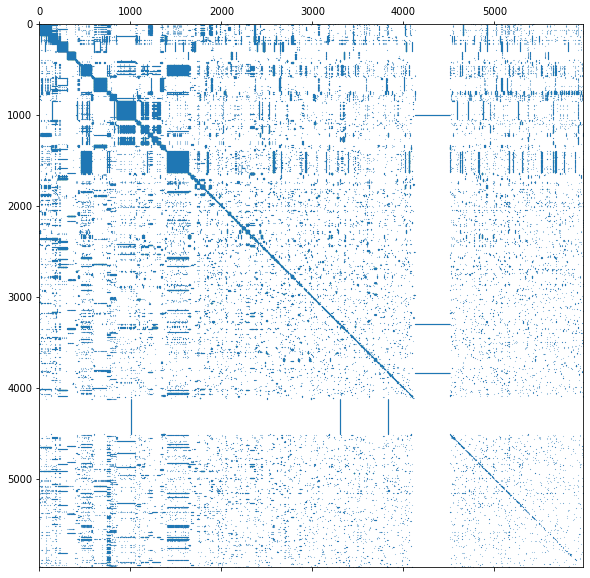

In [11]:
plt.figure(figsize=(10,10))
plt.spy(graph, markersize=.1);
plt.savefig(figpath+"sparsity.png")

Compute the **degree** of each node

In [12]:
degree=np.array(graph.sum(axis=1)).reshape((n,))
assert(np.sum(degree==0)==0) # make sure no node with zero degree

In [13]:
max_deg=np.max(degree)
print("max degree =", max_deg)

max degree = 855


Plot the **degree distribution**

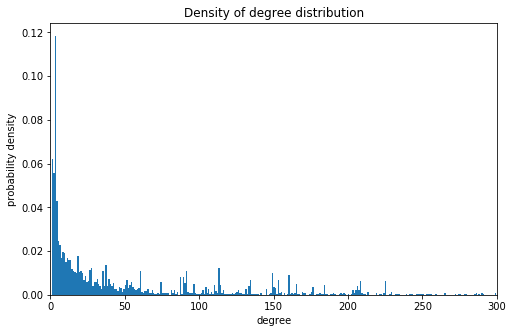

In [14]:
plt.figure(figsize=(8,5))
plt.hist(degree, bins=max_deg, density=True)
plt.xlim([0, 300])
plt.xlabel('degree')
plt.ylabel('probability density');
plt.title("Density of degree distribution")
plt.savefig(figpath+"deg_distr.pdf")

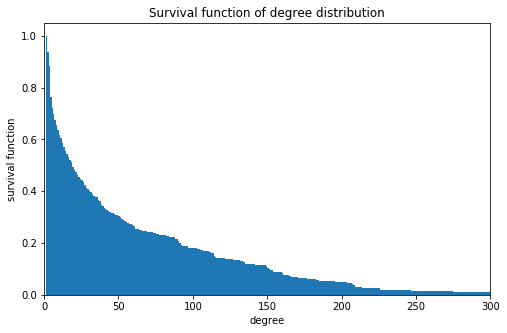

In [15]:
plt.figure(figsize=(8,5))
plt.hist(degree, bins=max_deg, cumulative=-1, density=True)
plt.xlim([0, 300])
plt.xlabel('degree')
plt.ylabel('survival function');
plt.title("Survival function of degree distribution")
plt.savefig(figpath+"deg_distr_surv.pdf")

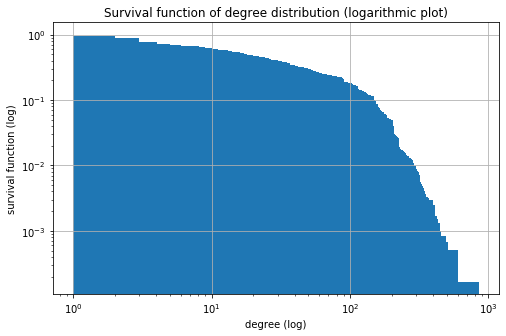

In [16]:
plt.figure(figsize=(8,5))
plt.hist(degree, bins=np.geomspace(degree.min(), degree.max(), max_deg), cumulative=-1, log=True, density=True)
plt.xscale('log')
plt.xlabel('degree (log)')

plt.ylabel('survival function (log)');
plt.title("Survival function of degree distribution (logarithmic plot)")
plt.grid(True)
plt.savefig(figpath+"deg_distr_surv_log.png")

In [17]:
max_eig=np.real(slinalg.eigs(graph.astype('f'), k=1)[0][0])
max_eig

208.01347

## Degree centrality

$C_{deg}(i)=\frac{d(i)}{\underset{j}{max}( d(j) )}$ 


In [18]:
C_deg=degree/max_deg

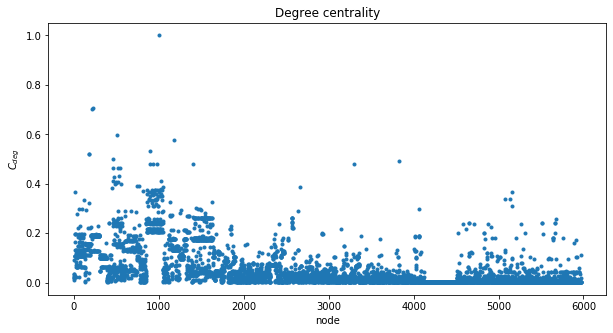

In [19]:
plt.figure(figsize=(10,5))
plt.plot(C_deg, '.')
plt.xlabel('node'), plt.ylabel('$C_{deg}$');
plt.title("Degree centrality")
plt.savefig(figpath+"deg_centrality.pdf")

## Katz centrality

for node $i$ the Katz centrality is defined as:

$x_i=\alpha \sum_{j}{A_{ij}x_{j}} + \beta_i$


which can be also expressed in matrix form: 

$\mathbf{x}=\alpha \mathbf{A} \mathbf{x} + \mathbf{\beta} \implies (\mathbf{I} - \alpha  \mathbf{A}) \mathbf{x}= \mathbf{\beta}$

In [20]:
1/max_eig # max alpha for convergence

0.004807380902412354

### Iterative

In [21]:
alpha=2e-3
beta=np.ones(n)
max_step=1000

In [22]:
C_ka_iter=np.ones(n)
for i in range(max_step):
    C_ka_iter=alpha*C_ka_iter*graph+beta

### Solving linear system

In [23]:
C_ka=slinalg.spsolve(sparse.eye(n, dtype=np.uint8) - (alpha*graph), beta)

In [24]:
C_ka_iter/=np.max(C_ka_iter)
C_ka/=np.max(C_ka)

The max absolute distance between computing $C_{ka}$ with the *iterative* or *linsys* method

In [25]:
np.max(np.abs(C_ka-C_ka_iter))

9.325873406851315e-15

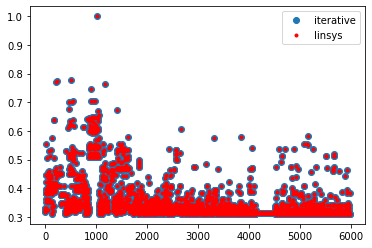

In [26]:
plt.plot(C_ka_iter, 'o')
plt.plot(C_ka, 'r.')
plt.legend(['iterative', 'linsys']);

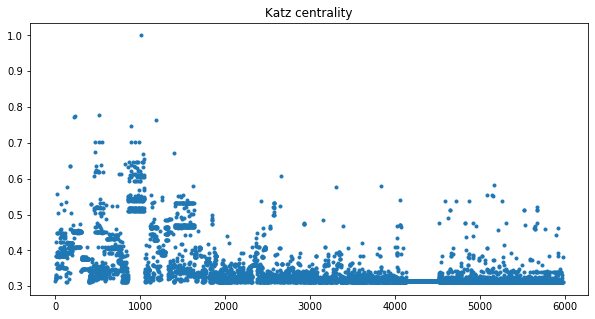

In [27]:
plt.figure(figsize=(10,5))
plt.plot(C_ka, '.')
plt.title("Katz centrality")
plt.savefig(figpath+"katz.pdf")

## Betweenness centrality

The Brandes algorithm is used to calculate the betweenness centrality

asymptotic cost $O(n m)$

In [28]:
@jit(nopython=True) #use JIT compilation to speedup execution time
def betweenness_centrality(n, ia, ja, max_p):
    C_b = np.zeros(n, dtype=np.float64)
    
    for s in range(n): #iterate on all nodes
        S = np.empty(n, dtype=np.uint32)
        S_ptr=0
        
        P = np.empty((n,max_p), dtype=np.uint32)
        P_ptr= np.zeros(n, dtype=np.uint32)
        
        
        sigma = np.zeros(n, dtype=np.uint32); sigma[s] = 1
        d = -np.ones(n,dtype=np.int32); d[s] = 0
        
        Q = np.empty(n,dtype=np.uint32)
        Q[0]=s
        Q_in=1
        Q_out=0

        while Q_out<Q_in:
            
            v = Q[Q_out]
            Q_out+=1
            
            S[S_ptr]=v
            S_ptr+=1
            
            for w in ja[ia[v]:ia[v + 1]]: # loop on neighbour of v
                if d[w] < 0:
                    Q[Q_in] = w
                    Q_in += 1
                    
                    d[w] = d[v] + 1
                    
                if d[w] == d[v] + 1:
                    sigma[w] +=sigma[v]
                    
                    if P_ptr[w]>=max_p:
                        raise ValueError("not enough space in P")
                    P[w,P_ptr[w]]=v
                    P_ptr[w]+=1
                    
        delta = np.zeros(n,dtype=np.float64)
        
        
        for w in S[S_ptr::-1]:
            for v in P[w,0:P_ptr[w]]:
                delta[v] += (sigma[v]/sigma[w]) * (1 + delta[w])
            if w != s:
                C_b[w] += delta[w]
    return C_b

In [29]:
C_betw=betweenness_centrality(n, graph.indptr, graph.indices, max_deg)
C_betw/=np.max(C_betw)

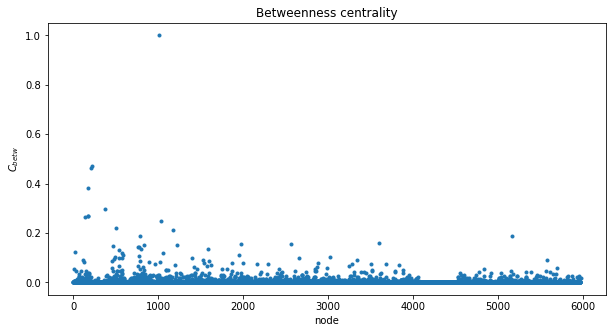

In [30]:
plt.figure(figsize=(10,5))
plt.plot(C_betw, '.')
plt.xlabel('node'), plt.ylabel('$C_{betw}$');
plt.title("Betweenness centrality")
plt.savefig(figpath+"betweenness.pdf")

## Comparing the considered centralities

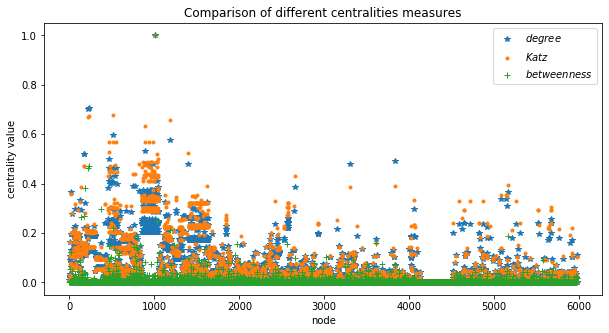

In [31]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.interp(C_deg, (C_deg.min(), C_deg.max()), (0,1)), '*')
plt.plot(np.interp(C_ka, (C_ka.min(), C_ka.max()), (0,1)), '.')
plt.plot(np.interp(C_betw, (C_betw.min(), C_betw.max()), (0,1)), '+')
plt.xlabel('node'), plt.ylabel("centrality value"), plt.legend(['$degree$', '$Katz$', '$betweenness$'])
plt.title("Comparison of different centralities measures")
plt.savefig(figpath+"comparison.pdf")

### Plot sorted for increasing $C_{ka}$

In [32]:
ind=C_ka.argsort()

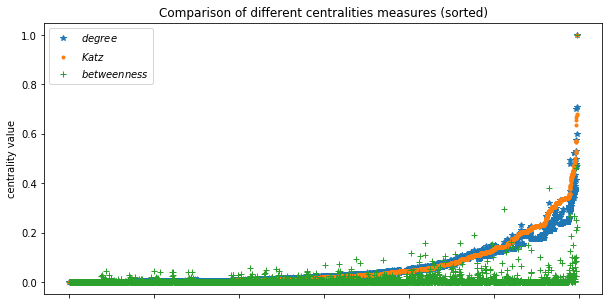

In [33]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.interp(C_deg[ind], (C_deg.min(), C_deg.max()), (0,1)), '*')
plt.plot(np.interp(C_ka[ind], (C_ka.min(), C_ka.max()), (0,1)), '.')
plt.plot(np.interp(C_betw[ind], (C_betw.min(), C_betw.max()), (0,1)), '+')
plt.ylabel("centrality value"), plt.legend(['$degree$', '$Katz$', '$betweenness$'])
plt.title("Comparison of different centralities measures (sorted)")
plt.tick_params(axis='x',labelbottom=False)
plt.savefig(figpath+"comparison_sort.pdf")

### Most important node according to the considered centralities

In [34]:
np.argmax(C_deg), np.argmax(C_ka), np.argmax(C_betw)

(1006, 1006, 1006)